In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Introduction

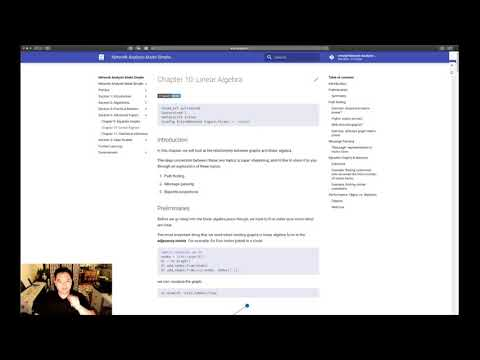

In [34]:
from IPython.display import YouTubeVideo

YouTubeVideo(id="uTHihJiRELc", width="100%")

In this chapter, we will look at the relationship between graphs and linear algebra.

The deep connection between these two topics is super interesting,
and I'd like to show it to you through an exploration of three topics:

1. Path finding
1. Message passing
1. Bipartite projections

## Preliminaries

Before we go deep into the linear algebra piece though,
we have to first make sure some ideas are clear.

The most important thing that we need
when treating graphs in linear algebra form
is the **adjacency matrix**.
For example, for four nodes joined in a chain:

In [2]:
import networkx as nx
nodes = list(range(4))
G1 = nx.Graph()
G1.add_nodes_from(nodes)
G1.add_edges_from(zip(nodes, nodes[1:]))

we can visualize the graph:

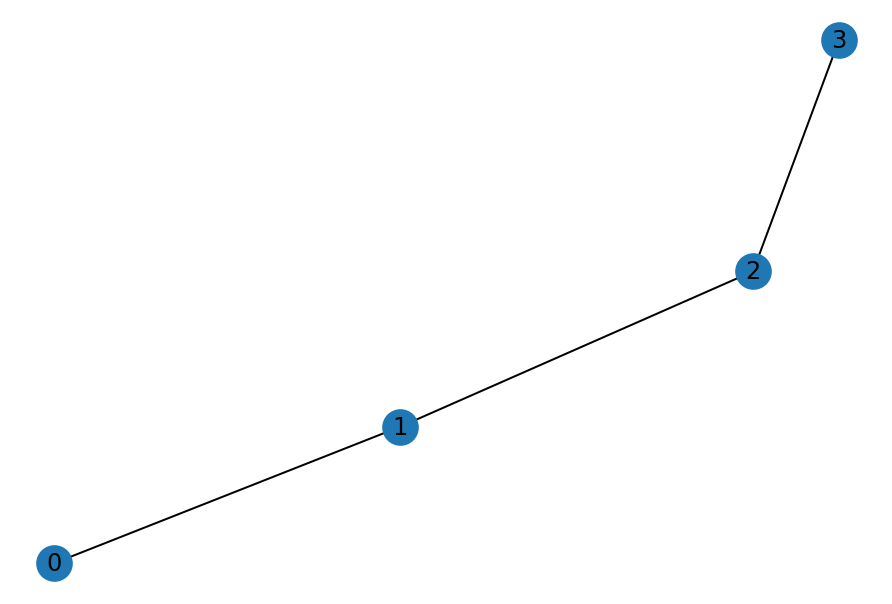

In [3]:
nx.draw(G1, with_labels=True)

and we can visualize its adjacency matrix:

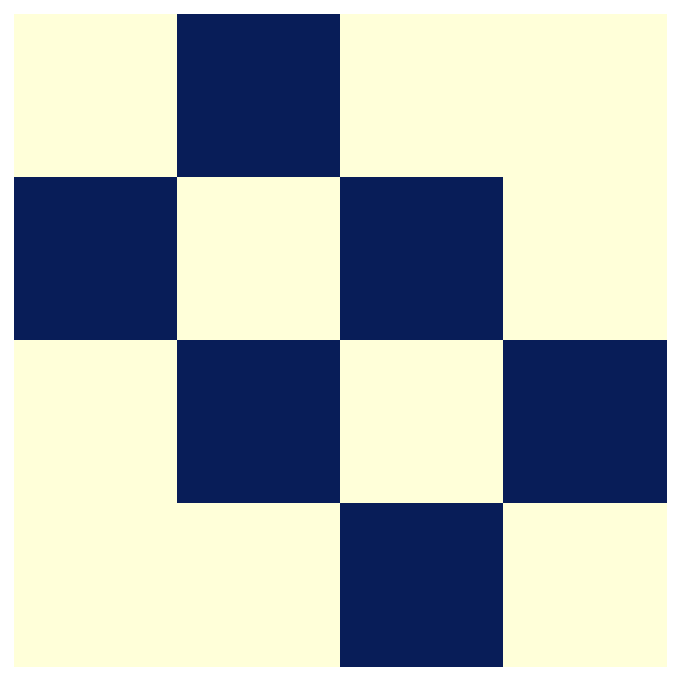

In [6]:
import nxviz as nv

m = nv.MatrixPlot(G1)
m.draw()

and we can obtain the adjacency matrix as a NumPy array:

In [7]:
A1 = nx.to_numpy_array(G1, nodelist=sorted(G1.nodes()))
A1

array([[0., 1., 0., 0.],
       [1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.]])

### Symmetry

Remember that for an undirected graph,
the adjacency matrix will be symmetric about the diagonal,
while for a directed graph,
the adjacency matrix will be _asymmetric_.

## Path finding

In the Paths chapter, we can use the breadth-first search algorithm
_to find a shortest path between any two nodes_.

As it turns out, using adjacency matrices, we can answer a related question,
which is _how many paths exist of length K between two nodes_.

To see how, we need to see the relationship between matrix powers and graph path lengths.

Let's take the adjacency matrix above,
raise it to the second power,
and see what it tells us.

In [8]:
import numpy as np
np.linalg.matrix_power(A1, 2)

array([[1., 0., 1., 0.],
       [0., 2., 0., 1.],
       [1., 0., 2., 0.],
       [0., 1., 0., 1.]])

> The diagonal element is the number of path you can take from any node and come back to such node with travelling of 2 (notice that outer node (0, and 3) has 1 while while those inner nodes (1,2) has 2 (i.e., from 1 u can either travel toward 0 or 2 to come back to 1 with 2 traversal))

> This corresponds to `degree` of that node !!

### Exercise: adjacency matrix power?

> What do you think the values in the adjacency matrix are related to?
> If studying in a group, discuss with your neighbors;
> if working on this alone, write down your thoughts.

In [9]:
import sys
if not (r'C:\Users\pui_s\Documents\concordia-bootcamps\Network-Analysis-Made-Simple' in sys.path):
    sys.path.insert(0, r'C:\Users\pui_s\Documents\concordia-bootcamps\Network-Analysis-Made-Simple')
from nams.solutions.linalg import adjacency_matrix_power
from nams.functions import render_html

render_html(adjacency_matrix_power())

### Higher matrix powers

The semantic meaning of adjacency matrix powers
is preserved even if we go to higher powers.
For example, if we go to the 3rd matrix power:

In [ ]:
np.linalg.matrix_power(A1, 3)

You should be able to convince yourself that:

1. There's no way to go from a node back to itself in 3 steps, thus explaining the diagonals, and 
1. The off-diagonals take on the correct values when you think about them in terms of "ways to go from one node to another".

### With directed graphs?

Does the "number of steps" interpretation hold
with directed graphs?
Yes it does!
Let's see it in action.

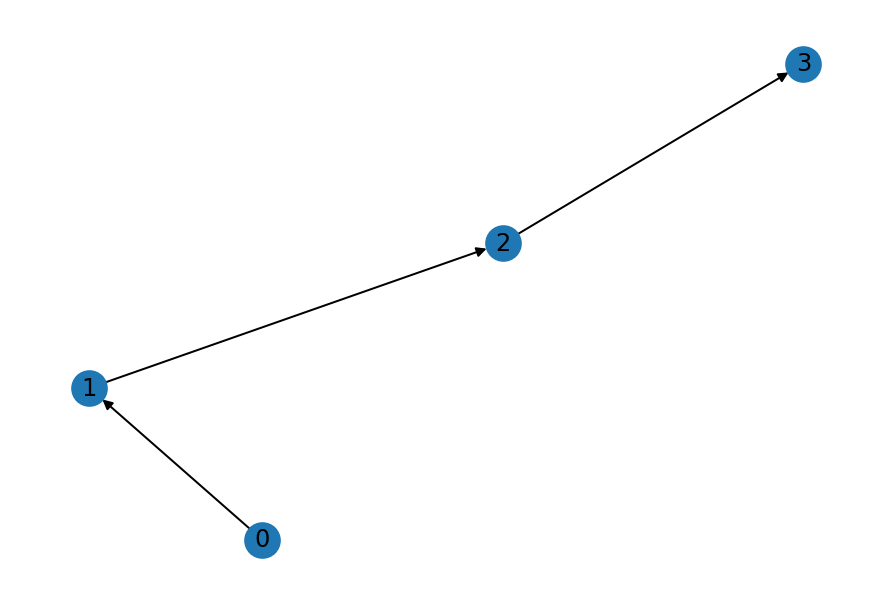

In [10]:
G2 = nx.DiGraph()
G2.add_nodes_from(nodes)
G2.add_edges_from(zip(nodes, nodes[1:]))
nx.draw(G2, with_labels=True)

### Exercise: directed graph matrix power

> Convince yourself that the resulting adjacency matrix power
> contains the same semantic meaning
> as that for an undirected graph,
> that is,
> _the number of ways to go from "row" node to "column" node
> in K steps_.
> (I have provided three different matrix powers for you.)

In [11]:
A2 = nx.to_numpy_array(G2)
np.linalg.matrix_power(A2, 2)

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

> This tells us that there is only 1 path traveling 2 edges from node 0 to node 1

> 0 path from 2 -> 0

In [12]:
np.linalg.matrix_power(A2, 3)

array([[0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [13]:
np.linalg.matrix_power(A2, 4)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

<hline>

## Message Passing

Let's now dive into the second topic here,
that of message passing.

To show how message passing works on a graph,
let's start with the directed linear chain,
as this will make things easier to understand.

### "Message" representation in matrix form

Our graph adjacency matrix contains nodes ordered in a particular fashion
along the rows and columns.
We can also create a "message" matrix $M$,
using the same ordering of nodes along the rows,
with columns instead representing a "message"
that is intended to be "passed" from one node to another:

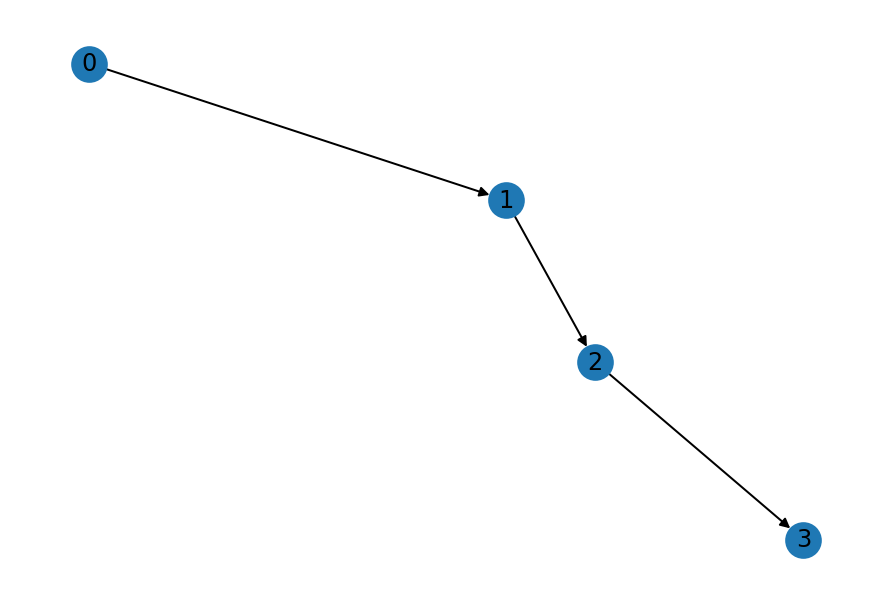

In [15]:
G2 = nx.DiGraph()
G2.add_nodes_from(nodes)
G2.add_edges_from(zip(nodes, nodes[1:]))
nx.draw(G2, with_labels=True)

In [14]:
M = np.array([1, 0, 0, 0])
M

array([1, 0, 0, 0])

Notice where the position of the value `1` is - at the first node.

If we take M and matrix multiply it against A2, let's see what we get:

In [16]:
msg2 = M @ A2
msg2

array([0., 1., 0., 0.])

The message has been passed onto the next node!
And if we pass the message one more time:

In [17]:
msg3 = M @ A2 @ A2
msg3 

array([0., 0., 1., 0.])

Now, the message lies on the 3rd node!

We can make an animation to visualize this more clearly. 
_There are comments in the code to explain what's going on!_

In [18]:
def propagate(G, msg, n_frames):
    """
    Computes the node values based on propagation.
    
    Intended to be used before or when being passed into the 
    anim() function (defined below).
    
    :param G: A NetworkX Graph.
    :param msg: The initial state of the message.
    :returns: A list of 1/0 representing message status at 
        each node.
    """
    # Initialize a list to store message states at each timestep.
    msg_states = []
    
    # Set a variable `new_msg` to be the initial message state.
    new_msg = msg
    
    # Get the adjacency matrix of the graph G.
    A = nx.to_numpy_array(G)
    
    # Perform message passing at each time step
    for i in range(n_frames):
        msg_states.append(new_msg)
        new_msg = new_msg @ A
        
    # Return the message states.
    return msg_states

RuntimeError: Requested MovieWriter (ffmpeg) not available

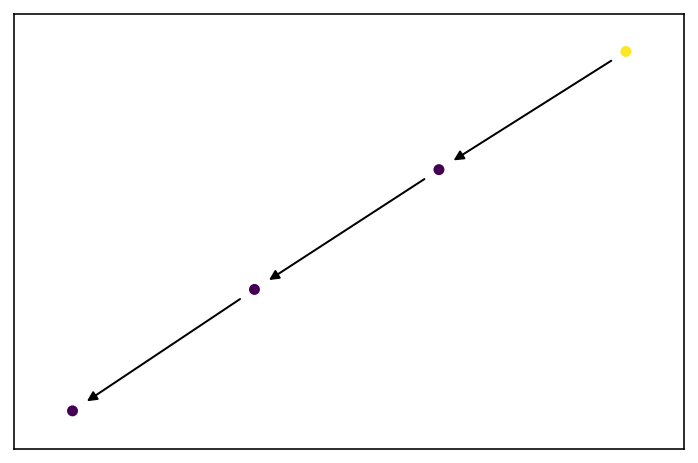

In [19]:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation

def update_func(step, nodes, colors):
    """
    The update function for each animation time step.
    
    :param step: Passed in from matplotlib's FuncAnimation. Must
        be present in the function signature.
    :param nodes: Returned from nx.draw_networkx_edges(). Is an
        array of colors.
    :param colors: A list of pre-computed colors.
    """
    nodes.set_array(colors[step].ravel())
    return nodes

def anim(G, initial_state, n_frames=4):
    """
    Animation function!
    """
    # First, pre-compute the message passing states over all frames.
    colors = propagate(G, initial_state, n_frames)
    # Instantiate a figure
    fig = plt.figure()
    # Precompute node positions so that they stay fixed over the entire animation
    pos = nx.kamada_kawai_layout(G)
    # Draw nodes to screen
    nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors[0].ravel(), node_size=20)
    # Draw edges to screen
    ax = nx.draw_networkx_edges(G, pos)
    # Finally, return the animation through matplotlib.
    return animation.FuncAnimation(fig, update_func, frames=range(n_frames), fargs=(nodes, colors))


# Initialize the message
msg = np.zeros(len(G2))
msg[0] = 1

# Animate the graph with message propagation.
HTML(anim(G2, msg, n_frames=4).to_html5_video())

## Bipartite Graphs & Matrices

The section on message passing above assumed unipartite graphs, or at least graphs for which messages can be meaningfully passed between nodes. 

In this section, we will look at bipartite graphs. 

Recall from before the definition of a bipartite graph:

- Nodes are separated into two partitions (hence 'bi'-'partite').
- Edges can only occur between nodes of different partitions.

Bipartite graphs have a natural matrix representation, known as the **biadjacency matrix**. Nodes on one partition are the rows, and nodes on the other partition are the columns.

NetworkX's `bipartite` module provides a function for computing the biadjacency matrix of a bipartite graph.

Let's start by looking at a toy bipartite graph, a "customer-product" purchase record graph, with 4 products and 3 customers. The matrix representation might be as follows:

In [20]:
# Rows = customers, columns = products, 1 = customer purchased product, 0 = customer did not purchase product.
cp_mat = np.array([[0, 1, 0, 0],
                   [1, 0, 1, 0],
                   [1, 1, 1, 1]])

From this "bi-adjacency" matrix, one can compute the projection onto the customers, matrix multiplying the matrix with its transpose.

In [21]:
c_mat = cp_mat @ cp_mat.T  # c_mat means "customer matrix"
c_mat

array([[1, 0, 1],
       [0, 2, 2],
       [1, 2, 4]])

What we get is the connectivity matrix of the customers, based on shared purchases. 
The diagonals are the degree of the customers in the original graph, 
i.e. the number of purchases they originally made, 
and the off-diagonals are the connectivity matrix, based on shared products.

To get the products matrix, we make the transposed matrix the left side of the matrix multiplication.

In [ ]:
p_mat = cp_mat.T @ cp_mat  # p_mat means "product matrix"
p_mat

You may now try to convince yourself that the diagonals are the number of times a customer purchased that product, and the off-diagonals are the connectivity matrix of the products, weighted by how similar two customers are.

### Exercises 

In the following exercises, you will now play with a customer-product graph from Amazon. This dataset was downloaded from [UCSD's Julian McAuley's website](http://jmcauley.ucsd.edu/data/amazon/), and corresponds to the digital music dataset.

This is a bipartite graph. The two partitions are:

- `customers`: The customers that were doing the reviews.
- `products`: The music that was being reviewed.

In the original dataset (see the original JSON in the `datasets/` directory), they are referred to as:

- `customers`: `reviewerID`
- `products`: `asin`

In [22]:
from nams import load_data as cf

G_amzn = cf.load_amazon_reviews()

100%|████████████████████████████████████████████████████████████████████████| 64706/64706 [00:00<00:00, 497708.81it/s]


Remember that with bipartite graphs, it is useful to obtain nodes from one of the partitions.

In [23]:
from nams.solutions.bipartite import extract_partition_nodes

In [24]:
customer_nodes = extract_partition_nodes(G_amzn, "customer")
mat = nx.bipartite.biadjacency_matrix(G_amzn, row_order=customer_nodes)

You'll notice that this matrix is extremely large! There are 5541 customers and 3568 products,
for a total matrix size of $5541 \times 3568 = 19770288$, but it is stored in a sparse format because only 64706 elements are filled in.

In [25]:
mat

<5541x3568 sparse matrix of type '<class 'numpy.intc'>'
	with 64706 stored elements in Compressed Sparse Row format>

### Example: finding customers who reviewed the most number of music items.

Let's find out which customers reviewed the most number of music items.

To do so, you can break the problem into a few steps.

First off, we compute the customer projection using matrix operations.

In [26]:
customer_mat = mat @ mat.T

Next, get the diagonals of the customer-customer matrix. Recall here that in `customer_mat`, the diagonals correspond to the degree of the customer nodes in the bipartite matrix.

SciPy sparse matrices provide a `.diagonal()` method that returns the diagonal elements.

In [27]:
# Get the diagonal.
degrees = customer_mat.diagonal()

Finally, find the index of the customer that has the highest degree.

In [28]:
cust_idx = np.argmax(degrees)
cust_idx

294

We can verify this independently by sorting the customer nodes by degree.

In [29]:
import pandas as pd
import janitor

# There's some pandas-fu we need to use to get this correct.
deg = (
    pd.Series(dict(nx.degree(G_amzn, customer_nodes)))
    .to_frame()
    .reset_index()
    .rename_column("index", "customer")
    .rename_column(0, "num_reviews")
    .sort_values('num_reviews', ascending=False)
)
deg.head()

AttributeError: 'DataFrame' object has no attribute 'rename_column'

Indeed, customer 294 was the one who had the most number of reviews!

### Example: finding similar customers

Let's now also compute which two customers are similar, based on shared reviews. To do so involves the following steps:

1. We construct a sparse matrix consisting of only the diagonals. `scipy.sparse.diags(elements)` will construct a sparse diagonal matrix based on the elements inside `elements`.
1. Subtract the diagonals from the customer matrix projection. This yields the customer-customer similarity matrix, which should only consist of the off-diagonal elements of the customer matrix projection.
1. Finally, get the indices where the weight (shared number of between the customers is highest. (*This code is provided for you.*)

In [30]:
import scipy.sparse as sp

In [31]:
# Construct diagonal elements.
customer_diags = sp.diags(degrees)
# Subtract off-diagonals.
off_diagonals = customer_mat - customer_diags
# Compute index of most similar individuals.
np.unravel_index(np.argmax(off_diagonals), customer_mat.shape)

(294, 86)

## Performance: Object vs. Matrices

Finally, to motivate why you might want to use matrices rather than graph objects to compute some of these statistics, let's time the two ways of getting to the same answer.

### Objects

Let's first use NetworkX's built-in machinery to find customers that are most similar.

In [32]:
from time import time

start = time()

# Compute the projection
G_cust = nx.bipartite.weighted_projected_graph(G_amzn, customer_nodes)

# Identify the most similar customers
most_similar_customers = sorted(G_cust.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[0]

end = time()
print(f'{end - start:.3f} seconds')
print(f'Most similar customers: {most_similar_customers}')

14.489 seconds
Most similar customers: ('A3HU0B9XUEVHIM', 'A9Q28YTLYREO7', {'weight': 154})


### Matrices

Now, let's implement the same thing in matrix form.

In [33]:
start = time()

# Compute the projection using matrices
mat = nx.bipartite.matrix.biadjacency_matrix(G_amzn, customer_nodes)
cust_mat = mat @ mat.T

# Identify the most similar customers
degrees = customer_mat.diagonal()
customer_diags = sp.diags(degrees)
off_diagonals = customer_mat - customer_diags
c1, c2 = np.unravel_index(np.argmax(off_diagonals), customer_mat.shape)

end = time()
print(f'{end - start:.3f} seconds')
print(f'Most similar customers: {customer_nodes[c1]}, {customer_nodes[c2]}, {cust_mat[c1, c2]}')

0.562 seconds
Most similar customers: A9Q28YTLYREO7, A3HU0B9XUEVHIM, 154


On a modern PC, the matrix computation should be about 10-50X faster
using the matrix form compared to the object-oriented form.
(The web server that is used to build the book
might not necessarily have the software stack to do this though,
so the time you see reported might not reflect the expected speedups.)
I'd encourage you to fire up a Binder session or clone the book locally 
to test out the code yourself.

You may notice that it's much easier to read the "objects" code, 
but the matrix code way outperforms the object code. 
This tradeoff is common in computing, and shouldn't surprise you.
That said, the speed gain alone is a great reason to use matrices!

## Acceleration on a GPU

If your appetite has been whipped up for even more acceleration
and you have a GPU on your daily compute,
then you're very much in luck!

The [RAPIDS.AI](https://rapids.ai) project has a package called [cuGraph](https://github.com/rapidsai/cugraph),
which provides GPU-accelerated graph algorithms.
As over release 0.16.0, all cuGraph algorithms will be able to accept NetworkX graph objects!
This came about through online conversations on GitHub and Twitter,
which for us, personally, speaks volumes to the power of open source projects!

Because cuGraph does presume that you have access to a GPU,
and because we assume most readers of this book might not have access to one easily,
we'll delegate teaching how to install and use cuGraph to the cuGraph devs and [their documentation][docs].
Nonetheless, if you do have the ability to install and use the RAPIDS stack,
definitely check it out!

[docs]: https://docs.rapids.ai/api/cugraph/stable/api.html